In [1]:
from fit.datamodules.tomo_rec import MNISTTomoFourierTargetDataModule
from fit.utils import convert2FC, fft_interpolate
from fit.utils.tomo_utils import get_proj_coords, get_img_coords

from fit.modules import TRecTransformerModule

from matplotlib import pyplot as plt

import torch

import numpy as np

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
seed_everything(22122020)

22122020

In [3]:
dm = MNISTTomoFourierTargetDataModule(root_dir='/data/mnist/', batch_size=32, num_angles=15)
dm.setup()

In [4]:
train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()
test_dl = dm.test_dataloader()

In [5]:
det_len = dm.gt_ds.get_ray_trafo().geometry.detector.shape[0]

In [6]:
proj_xcoords, proj_ycoords, src_flatten = get_proj_coords(angles=dm.gt_ds.get_ray_trafo().geometry.angles, 
                                                          det_len=det_len)
target_xcoords, target_ycoords, dst_flatten, order = get_img_coords(img_shape=dm.IMG_SHAPE, det_len=det_len)

In [7]:
model = TRecTransformerModule(d_model=256, y_coords_proj=proj_ycoords, x_coords_proj=proj_xcoords,
                             y_coords_img=target_ycoords, x_coords_img=target_xcoords, 
                             src_flatten_coords=src_flatten, dst_flatten_coords=dst_flatten, 
                             dst_order=order,
                             angles=dm.gt_ds.get_ray_trafo().geometry.angles, img_shape=dm.IMG_SHAPE,
                             detector_len=det_len,
                             init_bin_factor=3, bin_factor_cd=10, alpha=1.5,
                             lr=0.0001, weight_decay=0.01, loss_switch=0.1, attention_type='linear', n_layers=8,
                             n_heads=8, d_query=256//8, dropout=0.1, attention_dropout=0.1)

In [8]:
trainer = Trainer(max_epochs=100, 
                  gpus=1,
                  checkpoint_callback=ModelCheckpoint(
                                            filepath=None,
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Train/avg_val_mse',
                                            mode='min',
                                            prefix='best_val_loss_'
                                        ), 
                  deterministic=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [9]:
lr_finder = trainer.tuner.lr_find(model, 
                            train_dataloader=train_dl, val_dataloaders=val_dl, 
                            num_training=200, early_stop_threshold=4, min_lr=1e-8, max_lr=1e-1);


  | Name | Type            | Params
-----------------------------------------
0 | trec | TRecTransformer | 14.7 M
-----------------------------------------
14.7 M    Trainable params
0         Non-trainable params
14.7 M    Total params
/home/tbuchhol/Programs/miniconda3/envs/ft/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tbuchhol/Programs/miniconda3/envs/ft/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLo

/home/tbuchhol/Gitrepos/FourierImageTransformer/fit/utils/RAdam.py:119: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


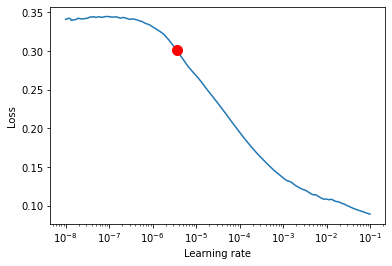

3.5892193464500514e-06


In [10]:
fig = lr_finder.plot(show=True, suggest=True)
print(lr_finder.suggestion())

In [11]:
model.hparams.lr = lr_finder.suggestion()

In [ ]:
trainer.fit(model, train_dl, val_dl);


  | Name | Type            | Params
-----------------------------------------
0 | trec | TRecTransformer | 14.7 M
-----------------------------------------
14.7 M    Trainable params
0         Non-trainable params
14.7 M    Total params


In [10]:
model = TRecTransformerModule.load_from_checkpoint('lightning_logs/version_0/checkpoints/best_val_loss_-last.ckpt', 
                           y_coords_proj=model.y_coords_proj,
                           x_coords_proj=model.x_coords_proj,
                           y_coords_img=model.y_coords_img,
                           x_coords_img=model.x_coords_img,
                           angles=model.angles)

In [11]:
test_res = trainer.test(model, test_dl)

/home/tbuchhol/Programs/miniconda3/envs/ft/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Mean PSNR': array(28.12889862060547, dtype=float32),
 'SEM PSNR': array(0.021727124229073524, dtype=float32),
 'Train/avg_val_loss': tensor(120.7053, device='cuda:0'),
 'Train/avg_val_mse': tensor(120.7053, device='cuda:0'),
 'val_loss': tensor(120.7053, device='cuda:0'),
 'val_mse': tensor(120.7053, device='cuda:0')}
--------------------------------------------------------------------------------


In [12]:
model = TRecTransformerModule.load_from_checkpoint('lightning_logs/version_0/checkpoints/best_val_loss_-epoch=187-step=1292499.ckpt', 
                           y_coords_proj=model.y_coords_proj,
                           x_coords_proj=model.x_coords_proj,
                           y_coords_img=model.y_coords_img,
                           x_coords_img=model.x_coords_img,
                           angles=model.angles)

In [13]:
test_res_best = trainer.test(model, test_dl)

/home/tbuchhol/Programs/miniconda3/envs/ft/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Mean PSNR': array(28.687192916870117, dtype=float32),
 'SEM PSNR': array(0.023102296516299248, dtype=float32),
 'Train/avg_val_loss': tensor(120.7053, device='cuda:0'),
 'Train/avg_val_mse': tensor(120.7053, device='cuda:0'),
 'val_loss': tensor(120.7053, device='cuda:0'),
 'val_mse': tensor(120.7053, device='cuda:0')}
--------------------------------------------------------------------------------
